<a href="https://colab.research.google.com/github/zakaria-grid/RFR/blob/master/Handwritten_Number_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#Import libraries

from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import pickle
import numpy as np
import joblib 
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [4]:
#Mount drive and read data
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/Handwritten_dataset'

Mounted at /content/gdrive
/content/gdrive/My Drive/Handwritten_dataset


#Data preprocessing: Cleaning, missing data, redundant data

In [8]:
# reading labels file
labels = pd.read_csv("images_labels.csv")

# converting column data to list
image_name = labels['image_name'].tolist()
labels = labels['output'].tolist()

#set a dataset dicrectory path
Dataset_directory='/content/gdrive/My Drive/Handwritten_dataset/images/'

# define the absolute path for all images
image_path= [Dataset_directory + s for s in image_name]

# X is the input (feautres) and Y is the output (labels) 
X=[]
Y=labels
for img in image_path:  # iterate over each image
     try: #catching potential errors realted to images
        img_array = cv2.imread(img ,cv2.IMREAD_GRAYSCALE)  # convert image to array
        X.append(img_array)
     except Exception as e:
        print("Error loading image", e, img)

**Save the preprocessed data for later usage**





In [9]:
#save X and Y
pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

#Load X and Y :
#pickle_in = open("X.pickle","rb")
#X = pickle.load(pickle_in)
#pickle_in = open("y.pickle","rb")
#y = pickle.load(pickle_in)

**Check the data distribution/Bias**



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


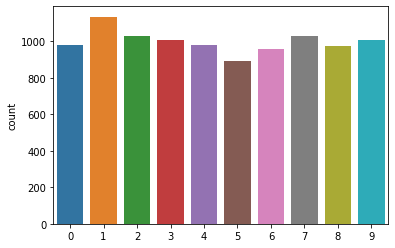

In [11]:
sns.countplot(labels)

**Spliting dataset into training (70%) and testing sets (30%)**

In [15]:
X=np.array(X).reshape((10000,28*28)) # Reshape X before training the model
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=30)

#Training/testing ML models

### **1) k-nearest neighbors (KNN) Model**

**a) Hypertuning & Training**

In [16]:
# select various prameter values
knn_param={
    'n_neighbors':[1,5,10,50,100],
    'weights':['uniform','distance']
}

# find out the optimal parameters
knn=GridSearchCV(KNeighborsClassifier(),knn_param,verbose=1,cv=5,n_jobs=-1, scoring='neg_mean_squared_error')

# train the model
knn_results=knn.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.8min finished


In [ ]:
X_test=X_test.reshape((2000,28*28))

**b) Testing and evaluating KNN performance** 

In [17]:
# Test the model using metrics
knn_predictions = knn.predict(X_test) 
mse_knn=mean_squared_error(y_test,knn_predictions)
accuracy_knn=accuracy_score(y_test, knn_predictions)
confusion_matrix_knn=confusion_matrix(y_test, knn_predictions)
kappa_knn=cohen_kappa_score(y_test, knn_predictions)



In [18]:
# print out resutls
print("\nKNN model performances:")
print("Accuracy " "% s" %  "{:.2f}".format(accuracy_knn*100) +"%")
print("Mean Squared Error (MSE) "  "% s" %  (mse_knn)) 
print("Kappa " "% s" % "{:.2f}".format(kappa_knn*100)+"%")
print("Confusion Matrix")
print(confusion_matrix_knn)


KNN model performances:
Accuracy 93.60%
Mean Squared Error (MSE) 1.152
Kappa 92.88%
Confusion Matrix
[[203   1   1   0   0   4   1   0   1   0]
 [  0 225   0   0   0   0   0   0   0   0]
 [  0   6 162   3   2   1   2   9   3   0]
 [  0   3   1 185   0   6   0   1   2   1]
 [  0   1   1   0 159   0   0   0   1   8]
 [  2   0   0   4   0 164   3   0   1   1]
 [  0   2   0   0   0   0 190   1   0   0]
 [  0   7   0   0   0   0   0 191   0   5]
 [  1   4   3   7   0   7   0   2 187   3]
 [  0   1   0   1   7   1   0   5   1 206]]


**c) Test the trained KNN model on few images**


In [19]:
for i in range(808,816):
  input_image_test=X_test[i].reshape(1,28*28)
  knn.predict(input_image_test)
  print("Predicted value: "  "% s" % knn.predict(input_image_test))
  print("Actual value "  "% s" % y_test[i])


Predicted value: [3]
Actual value 3
Predicted value: [9]
Actual value 9
Predicted value: [3]
Actual value 3
Predicted value: [9]
Actual value 9
Predicted value: [3]
Actual value 3
Predicted value: [2]
Actual value 2
Predicted value: [3]
Actual value 3
Predicted value: [9]
Actual value 9


**d) Save the trained model**

In [22]:
#Save the model on the drive to use it later

knn_model = 'knn_model.sav'
joblib.dump(knn_model, knn_model)

['knn_model.sav']

### **2) Random Forest (RF)**


**a) Hypertuning & Training**

In [21]:
#select various prameter values
rf_param = { 
    'n_estimators': [100, 1000, 10000],
    'max_features': ['None', 'sqrt', 'log2'],
    'max_depth' : [4,6]
}

# find out the optimal parameters
rf=GridSearchCV(RandomForestClassifier(),rf_param,verbose=1,cv=5,n_jobs=-1)

# train the model
rf.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 23.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

**b) Testing and evaluating RF performance**

In [23]:
# test the model using metrics

rf_predictions = rf.predict(X_test) 
mse_rf=mean_squared_error(y_test,rf_predictions)
accuracy_rf=accuracy_score(y_test, rf_predictions)
confusion_matrix_rf=confusion_matrix(y_test, rf_predictions)
kappa_rf=cohen_kappa_score(y_test, rf_predictions)

In [24]:
#print out results

print("\nRF model performances:")
print("Accuracy " "% s" %  "{:.2f}".format(accuracy_rf*100) +"%")
print("Mean Squared Error (MSE) "  "% s" %  (mse_rf)) 
print("Kappa " "% s" % "{:.2f}".format(kappa_rf*100)+"%")
print("Confusion Matrix")
print(confusion_matrix_rf)


RF model performances:
Accuracy 87.00%
Mean Squared Error (MSE) 2.3875
Kappa 85.54%
Confusion Matrix
[[205   2   0   1   0   1   0   1   1   0]
 [  0 223   0   0   0   0   0   1   1   0]
 [  3   4 156   5   4   0   3  11   2   0]
 [  1   4   2 179   0   5   0   3   2   3]
 [  1   3   1   0 152   0   5   1   0   7]
 [  7   6   1  29   5 120   1   1   3   2]
 [  6   2   1   1   1   4 173   4   1   0]
 [  2   8   5   3   1   0   0 180   1   3]
 [  2  17   4   9   5   3   1   2 168   3]
 [  0   5   1   2  10   3   1  14   2 184]]


**c) Test the trained RF model om few samples**


In [25]:
for i in range(68,75):
  input_image_test=X_test[i].reshape(1,28*28)
  knn.predict(input_image_test)
  print("Predicted value: "  "% s" % rf.predict(input_image_test))
  print("Actual value "  "% s" % y_test[i])

Predicted value: [8]
Actual value 8
Predicted value: [5]
Actual value 5
Predicted value: [9]
Actual value 9
Predicted value: [6]
Actual value 6
Predicted value: [0]
Actual value 0
Predicted value: [1]
Actual value 1
Predicted value: [6]
Actual value 6


**d) Save the trained model**

In [26]:
#Save the model on the drive to use it later

import joblib 

rf_model = 'rf_model.sav'
joblib.dump(rf_model, rf_model)

['rf_model.sav']

### **3) Suppor Vector Machine**

**a) Hypertuning & Training**

In [37]:
svm_param = { 
    'kernel': ['sigmoid', 'rbf', 'poly'],
    'C': [1,10]
}

# find out the optimal parameters
svm=GridSearchCV(svm.SVC(),svm_param,verbose=1,cv=5,n_jobs=-1, scoring='neg_mean_squared_error')

# train the model
svm_results=svm.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.2min finished


**b) Testing and evaluating SVM performance**

In [38]:
# test the model using metrics

svm_predictions = svm.predict(X_test) 
mse_svm=mean_squared_error(y_test,svm_predictions)
accuracy_svm=accuracy_score(y_test, svm_predictions)
confusion_matrix_svm=confusion_matrix(y_test, svm_predictions)
kappa_svm=cohen_kappa_score(y_test, svm_predictions)

In [39]:
#print out results

print("\nSVM model performances:")
print("Accuracy " "% s" %  "{:.2f}".format(accuracy_svm*100) +"%")
print("Mean Squared Error (MSE) "  "% s" %  (mse_svm)) 
print("Kappa " "% s" % "{:.2f}".format(kappa_svm*100)+"%")
print("Confusion Matrix")
print(confusion_matrix_svm)


SVM model performances:
Accuracy 96.10%
Mean Squared Error (MSE) 0.675
Kappa 95.66%
Confusion Matrix
[[206   0   0   0   0   2   1   0   2   0]
 [  0 223   1   0   0   1   0   0   0   0]
 [  0   0 176   3   1   1   2   3   0   2]
 [  0   0   2 190   0   2   0   2   1   2]
 [  0   0   0   0 167   0   1   0   0   2]
 [  0   1   0   4   0 165   3   0   2   0]
 [  1   2   0   0   2   1 186   0   1   0]
 [  0   1   3   0   2   0   0 193   0   4]
 [  1   0   2   6   2   3   1   0 197   2]
 [  0   0   0   0   1   2   0   0   0 219]]


**d) Save the trained model**

In [48]:
#Save the model on the drive to use it later

import joblib 

svm_model = 'svm_model.sav'
joblib.dump(svm_model, svm_model)

['svm_model.sav']

#Compare models' performance

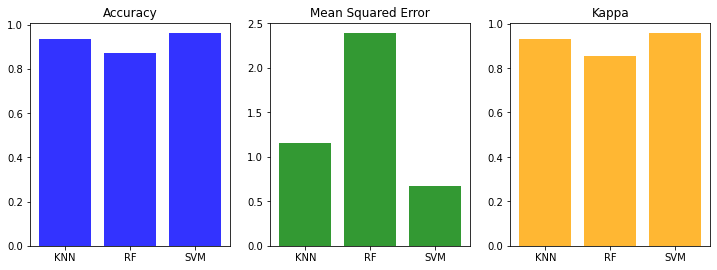

In [49]:
models = ('KNN','RF','SVM')
y_pos = np.arange(len(models))
mse = [mse_knn,mse_rf,mse_svm]
accuracy=[accuracy_knn,accuracy_rf,accuracy_svm]
kappa= [kappa_knn,kappa_rf,kappa_svm]


fig = plt.figure()
fig.subplots_adjust( right=1.7, top=.9)
for i in range(1, 4):
  if i==1:
    ax = fig.add_subplot(1, 3, i)
    ax.bar(y_pos, accuracy, align='center', alpha=0.8, color='b')
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(('KNN','RF','SVM'), minor=False)
    ax.set_label('Accuracy')
    ax.set_title('Accuracy')
  if i==2:
    ax = fig.add_subplot(1, 3, i)
    ax.bar(y_pos, mse, align='center', alpha=0.8, color='g')
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, fontdict=None, minor=False)
    ax.set_label('MSE')
    ax.set_title('Mean Squared Error')
  if i==3:
    ax = fig.add_subplot(1, 3, i)
    ax.bar(y_pos, kappa, align='center', alpha=0.8, color='orange')
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, fontdict=None, minor=False)
    ax.set_label('Kappa')
    ax.set_title('Kappa')